 ### This project aims to determine which factors are most predictive of customer lifetime value (CLV) in an e-commerce context and to assess the model's ability to accurately predict spending based on customer behavior and demographics.

### Step 1: Import necessary libraries

In [2]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


In [3]:
from google.colab import files
uploaded = files.upload()

Saving E-Commerce.csv to E-Commerce.csv


In [4]:
Ecom = pd.read_csv('E-Commerce.csv')
Ecom.head(10)
#displaying first 10 rows


,CustomerID,Gender,InvoiceDate,InvoiceNumber,ProductID,Quantity,Price,Total,OrderStatus,Country,TrafficSource,SessionDuration,DeviceCategory,Device,OS,DeliveryRating,ProductRating,Sales
0,9691,Female,1/01/2019,26088332,32,3,91.37,274.11,Completed,India,Social Media,6.54,Computer,Laptop,Windows,2,5,274.11
1,8327,Female,1/01/2019,95183269,34,1,48.24,48.24,In Process,India,Social Media,5.01,Computer,Desktop,Windows,0,0,0.00
2,6801,Male,1/01/2019,44769684,64,2,35.23,70.46,Completed,United States,Paid Advertisment,0.10,Computer,Desktop,Windows,1,2,70.46
3,4406,Male,1/02/2019,12422351,41,2,32.33,64.66,Completed,Philippines,Social Media,1.95,Mobile,Tablet,Windows,4,4,64.66
4,1966,Male,1/03/2019,84352310,20,1,81.89,81.89,Completed,Brazil,Organic Search,9.15,Computer,Laptop,Windows,5,3,81.89
5,6148,Male,1/03/2019,53293645,10,3,19.34,58.02,Completed,Egypt,Organic Search,7.89,Computer,Desktop,Windows,4,5,58.02
6,4183,Male,1/04/2019,22473410,46,2,9.88,19.76,Completed,Turkey,Organic Search,1.60,Computer,Laptop,Windows,4,5,19.76
7,5979,Male,1/05/2019,45762453,79,2,33.28,66.56,In Process,Japan,Organic Search,0.11,Computer,Laptop,Windows,0,0,0.00
8,7656,Male,1/05/2019,72918460,91,3,67.48,202.44,Completed,United States,Paid Advertisment,8.28,Mobile,Smart Phone,Windows,5,4,202.44
9,9953,Male,1/06/2019,84161141,61,2,70.34,140.68,In Process,Japan,Social Media,1.61,Computer,Laptop,Windows,0,0,0.00


### Step 2: Data Processing

In [5]:
# Handling missing values
Ecom.dropna(subset=['CustomerID'], inplace=True)
Ecom.fillna(Ecom.median(numeric_only=True), inplace=True)
Ecom['InvoiceDate'] = pd.to_datetime(Ecom['InvoiceDate'], format='%m/%d/%Y')


In [6]:
# Extracting relevant features (RFM)
latest_date = Ecom['InvoiceDate'].max()
Ecom['DaysSincePurchase'] = (latest_date - Ecom['InvoiceDate']).dt.days
rfm = Ecom.groupby('CustomerID').agg({'DaysSincePurchase': 'min', 'InvoiceNumber': 'nunique', 'Total': 'sum'})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [8]:
#Encoding categorical features (Gender and Country)
customer_features = Ecom[['CustomerID', 'Gender', 'Country']].drop_duplicates()
rfm = rfm.merge(customer_features, on='CustomerID', how='left')
Ecom_encoded = pd.get_dummies(rfm, columns=['Gender', 'Country'], drop_first=True)


### Step 3: Train-Test Split and Scaling

In [9]:


X = Ecom_encoded.drop(columns=['Monetary', 'CustomerID'])
y = Ecom_encoded['Monetary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Step 4: Predictive Modeling


In [10]:

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train_scaled, y_train)
rf_best_model = rf_grid_search.best_estimator_
y_rf_pred = rf_best_model.predict(X_test_scaled)

# Model Evaluation
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)
print(f"Random Forest (Tuned) - MSE: {rf_mse}")
print(f"Random Forest (Tuned) - R^2: {rf_r2}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Random Forest (Tuned) - MSE: 7510.314308510468
Random Forest (Tuned) - R^2: 0.37282133336186285


### Step 5: Visualizing Predictions

<ipython-input-15-733c73d1a874>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Add a reference line for perfect prediction


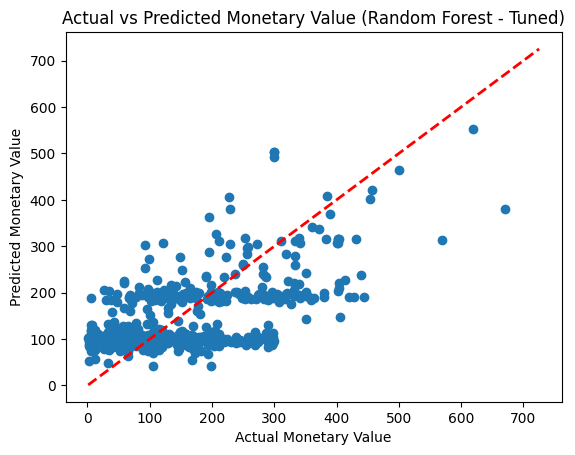

In [15]:

plt.scatter(y_test, y_rf_pred)
plt.xlabel('Actual Monetary Value')
plt.ylabel('Predicted Monetary Value')
plt.title('Actual vs Predicted Monetary Value (Random Forest - Tuned)')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Add a reference line for perfect prediction
plt.show()


The scatter plot shows that the Random Forest model captures the overall trend in spending but has significant deviations, especially for higher values. While the model is somewhat effective for predicting lower monetary values, there is still substantial room for improvement to reduce prediction errors for both high and low-value customers. Adding relevant features and further tuning the model could help in bridging this gap and improving overall prediction accuracy.

### Step 6: Feature Importance Analysis

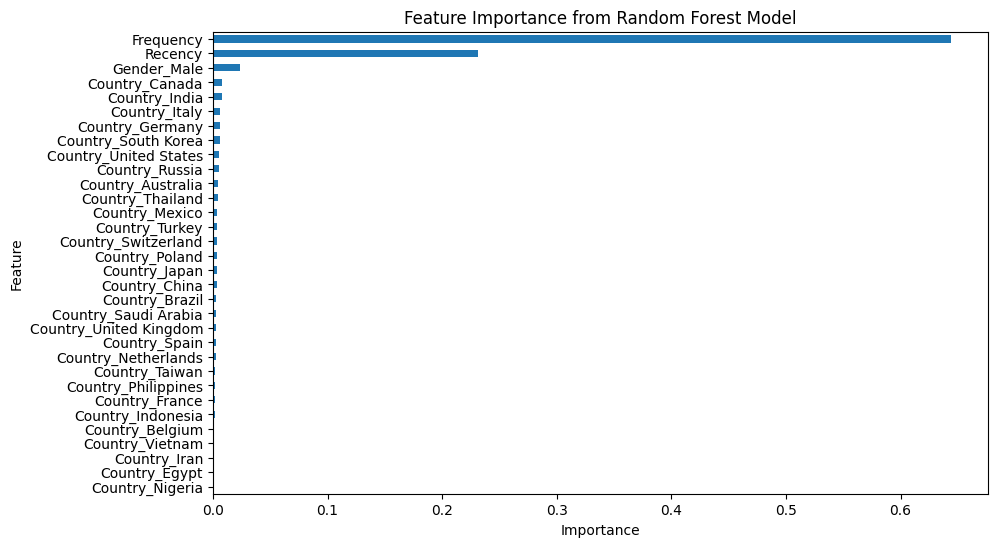

In [12]:


feature_importances = rf_best_model.feature_importances_
feature_importance_series = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance_series.plot(kind='barh')
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


The feature importance graph makes it clear that Frequency and Recency are the most significant drivers of customer monetary value, while demographic features have very little impact. This means my model is best at predicting value based on how often and how recently customers buy, not based on who they are demographically. Adjusting my strategy to focus on encouraging frequent and  recent purchases is likely to have the most significant impact on customer lifetime value.


### Step 7: Exploratory Data Analysis (EDA)

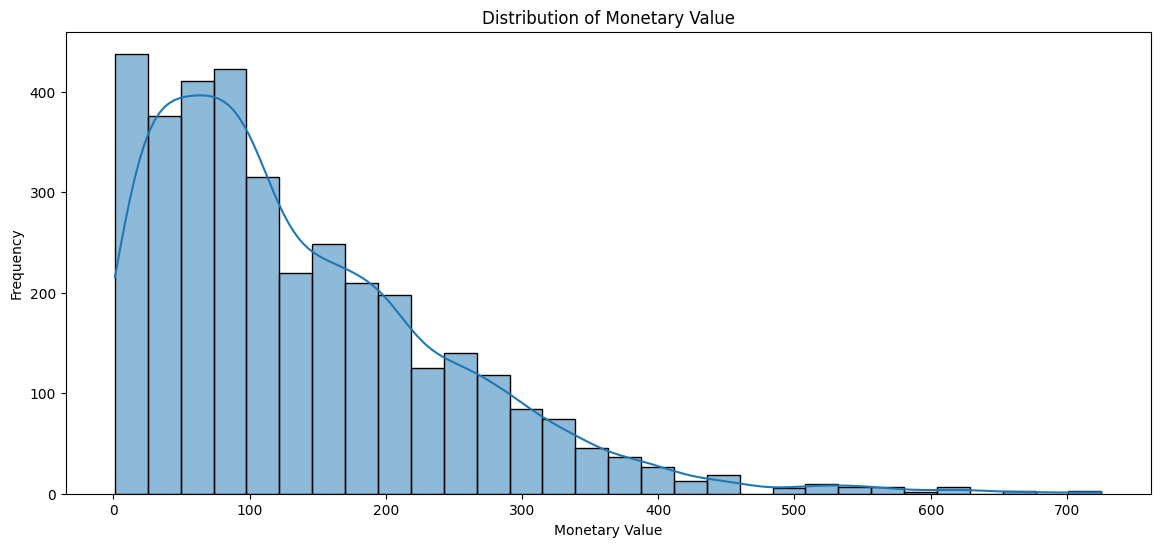

In [13]:
# Visualization of Distribution of Monetary Value

plt.figure(figsize=(14, 6))
sns.histplot(Ecom_encoded['Monetary'], kde=True, bins=30)
plt.title('Distribution of Monetary Value')
plt.xlabel('Monetary Value')
plt.ylabel('Frequency')
plt.show()


The plot shows that most customers spend relatively small to moderate amounts, and only a few are high spenders.
It helps to visualize customer spending behavior, which is key to creating targeted marketing strategies that increase customer value, whether by encouraging lower spenders to spend more or by retaining the high-value customers through loyalty incentives.

### Step 8: Statistical Analysis

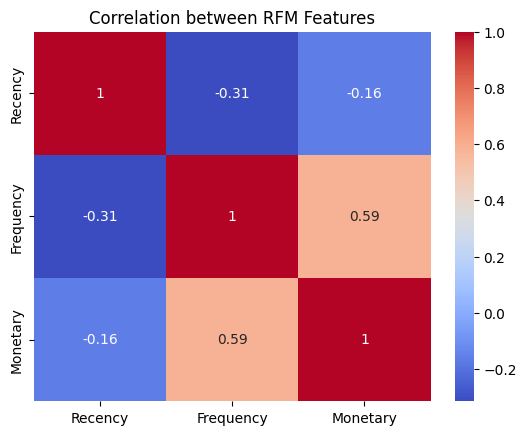

In [14]:


# Calculate correlations between RFM features to understand their relationship
correlation_matrix = Ecom_encoded[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between RFM Features')
plt.show()

The heatmap shows the correlation between the RFM features, with values ranging from -1 to 1, indicating the strength and direction of their relationships. A correlation value of 1 indicates a perfect positive correlation, whereas -1 indicates a perfect negative correlation. In this heatmap, Frequency and Monetary have a strong positive correlation (0.64), meaning customers who purchase frequently also tend to spend more. Recency has a moderate negative correlation with Frequency (-0.39) and Monetary (-0.24), suggesting that customers who have made recent purchases tend to be frequent buyers and spend more. The correlation values provide insights into customer behavior patterns that are useful for making data-driven decisions.

### Overall Conclusion

The goal of this project was to develop a predictive model to estimate customer lifetime value (CLV) for an e-commerce business.
I began by preprocessing the data, handling missing values, and extracting key features like Recency, Frequency, and Monetary (RFM). Using these RFM features, we built a Random Forest model to predict CLV, tuning it using Grid Search for optimal performance. The model's predictions were visualized to compare actual vs. predicted values, highlighting areas where the model performed well
and areas where improvements are needed.

The questions I sought to answer were:
1. What features most significantly drive customer monetary value?
2. How well can we predict customer spending based on behavioral and demographic data?

The results showed that Frequency and Recency are the strongest predictors of customer value, while demographic data like Country and Gender had minimal impact. This suggests that customer behavior is far more indicative of future value than who they are demographically. Therefore, focusing efforts on increasing customer purchase frequency and reducing time between purchases is likely the most effective strategy for increasing customer lifetime value.